In [9]:
import numpy as np
import random
import torch
import torch.nn as nn
import gym
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib.patches as patches

class Qfunction(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.linear_1 = nn.Linear(state_dim, 64)
        self.linear_2 = nn.Linear(64, 64)
        self.linear_3 = nn.Linear(64, action_dim)
        self.activation = nn.LeakyReLU(0.1)

    def forward(self, states):
        hidden = self.linear_1(states)
        hidden = self.activation(hidden)
        hidden = self.linear_2(hidden)
        hidden = self.activation(hidden)
        actions = self.linear_3(hidden)
        return actions

In [10]:
%matplotlib inline

In [11]:
env = gym.make('LunarLander-v2',continuous = True)

In [12]:
class SDQN:
    def __init__(self, state_dim, action_dim, gamma=0.993, lr=1e-3, batch_size=128, epsilon_decrease=0.01, epsilon_min=0.03):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.q_function = Qfunction(self.state_dim, self.action_dim)
        self.q_function_ = Qfunction(self.state_dim, self.action_dim)
        for target_param in self.q_function_.parameters():
            target_param.data.copy_(target_param.data)
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = 1
        self.epsilon_decrease = epsilon_decrease
        self.epsilon_min = epsilon_min
        self.memory = []
        self.memory_lim = 150000
        self.optimzaer = torch.optim.Adam(self.q_function.parameters(), lr=lr)

    def get_action(self, state, target= False):
        if(target):
            q_values = self.q_function_(torch.FloatTensor(state))
        else:
            q_values = self.q_function(torch.FloatTensor(state))
        argmax_action = torch.argmax(q_values,dim=-1)
        probs = self.epsilon * np.ones((argmax_action.shape[0],self.action_dim)) / self.action_dim
        probs[np.arange(argmax_action.shape[0]),argmax_action] += 1 - self.epsilon
        action = np.ones(q_values.shape[0], dtype=np.int32)
        for sample in range(q_values.shape[0]):
            action[sample] = np.random.choice(np.arange(self.action_dim), p=probs[sample,:])
        return action
    
    def fit(self, state, action, reward, done, next_state, tau):
        self.memory.append([state, action, reward, int(done), next_state])
        if(len(self.memory)>self.memory_lim):
            self.memory = self.memory[int(self.memory_lim*0.05):]
            self.memory = random.sample(self.memory, int(self.memory_lim*0.9))
            print('clear memory')
        if len(self.memory) > self.batch_size:
            batch = random.sample(self.memory, self.batch_size)
            states, actions, rewards, dones, next_states = map(torch.tensor, list(zip(*batch)))
    
            targets = rewards + self.gamma * (1 - dones) * torch.max(self.q_function_(next_states), dim=1).values
            q_values = self.q_function(states)[torch.arange(self.batch_size), actions]
            
            loss = torch.mean((q_values - targets.detach()) ** 2)
            loss.backward()
            self.optimzaer.step()
            self.optimzaer.zero_grad()
            
            self.soft_update(self.q_function,self.q_function_, tau)
            
            if self.epsilon > self.epsilon_min:
                self.epsilon -= self.epsilon_decrease
                
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [13]:
%%time
state_dim = env.observation_space.shape[0]
action_dim = 6

episode_n = 1000
t_max = 1000

agent_s = SDQN(state_dim, action_dim,epsilon_decrease=0.03/2000)
action_dict = [[0,0],[1,0],[1,-1],[1,1],[0,1],[0,-1]]

hist_s = []
hist_s_v = []
hist_s_v_disc = []
hist_s_v_ = []
hist_s_v_disc_ = []

for episode in range(episode_n):
    total_reward = 0

    state = env.reset()
    for t in range(t_max):
        action = agent_s.get_action([state])
        next_state, reward, done, _ = env.step(action_dict[action[0]])

        total_reward += reward
        agent_s.fit(state, int(action), reward, done, next_state,tau = 0.005)

        state = next_state

        if done:
            break
    
    hist_s.append(total_reward)
    
    #validate
    if(episode%10 == 0):
        eps = agent_s.epsilon
        agent_s.epsilon = 0
        total_reward = 0
        total_reward_disc = 0
        rew_mult = 1
        state = env.reset()
        for t in range(t_max):
            action = agent_s.get_action([state], True)
            next_state, reward, done, _ = env.step(action_dict[action[0]])

            total_reward += reward
            
            total_reward_disc += rew_mult*reward
            rew_mult *= agent_s.gamma

            state = next_state

            if done:
                break
        agent_s.epsilon = eps
        
        hist_s_v_.append(total_reward)
        hist_s_v_disc_.append(total_reward_disc)
        
    
    if(episode%10 == 0):
        eps = agent_s.epsilon
        agent_s.epsilon = 0
        total_reward = 0
        total_reward_disc = 0
        rew_mult = 1
        state = env.reset()
        for t in range(t_max):
            action = agent_s.get_action([state], False)
            next_state, reward, done, _ = env.step(action_dict[action[0]])

            total_reward += reward
            
            total_reward_disc += rew_mult*reward
            rew_mult *= agent_s.gamma

            state = next_state

            if done:
                break
        agent_s.epsilon = eps
        
        hist_s_v.append(total_reward)
        hist_s_v_disc.append(total_reward_disc)

    print(f'episode: {episode}, \
rew: {round(np.mean(hist_s[-100:]),2)}, \
v_: {round(np.mean(hist_s_v_[-10:]),2)}, \
v_disc_: {round(np.mean(hist_s_v_disc_[-10:]),2)}, \
v: {round(np.mean(hist_s_v[-10:]),2)}, \
v_disc: {round(np.mean(hist_s_v_disc[-10:]),2)}, \
epsilon: {round(agent_s.epsilon,2)}, \
mem: {len(agent_s.memory)}')

episode: 0, rew: -404.43, v_: -645.32, v_disc_: -396.64, v: -1497.55, v_disc: -191.7, epsilon: 1.0, mem: 270
episode: 1, rew: -300.81, v_: -645.32, v_disc_: -396.64, v: -1497.55, v_disc: -191.7, epsilon: 1.0, mem: 443
episode: 2, rew: -326.98, v_: -645.32, v_disc_: -396.64, v: -1497.55, v_disc: -191.7, epsilon: 0.99, mem: 569
episode: 3, rew: -337.46, v_: -645.32, v_disc_: -396.64, v: -1497.55, v_disc: -191.7, epsilon: 0.99, mem: 658
episode: 4, rew: -359.16, v_: -645.32, v_disc_: -396.64, v: -1497.55, v_disc: -191.7, epsilon: 0.99, mem: 838
episode: 5, rew: -358.4, v_: -645.32, v_disc_: -396.64, v: -1497.55, v_disc: -191.7, epsilon: 0.99, mem: 966
episode: 6, rew: -370.45, v_: -645.32, v_disc_: -396.64, v: -1497.55, v_disc: -191.7, epsilon: 0.98, mem: 1129
episode: 7, rew: -371.42, v_: -645.32, v_disc_: -396.64, v: -1497.55, v_disc: -191.7, epsilon: 0.98, mem: 1365
episode: 8, rew: -358.18, v_: -645.32, v_disc_: -396.64, v: -1497.55, v_disc: -191.7, epsilon: 0.98, mem: 1474
episode: 9

episode: 75, rew: -296.06, v_: -164.84, v_disc_: -53.3, v: -303.61, v_disc: -55.5, epsilon: 0.82, mem: 12013
episode: 76, rew: -292.33, v_: -164.84, v_disc_: -53.3, v: -303.61, v_disc: -55.5, epsilon: 0.82, mem: 12146
episode: 77, rew: -290.26, v_: -164.84, v_disc_: -53.3, v: -303.61, v_disc: -55.5, epsilon: 0.82, mem: 12319
episode: 78, rew: -291.99, v_: -164.84, v_disc_: -53.3, v: -303.61, v_disc: -55.5, epsilon: 0.81, mem: 12538
episode: 79, rew: -289.04, v_: -164.84, v_disc_: -53.3, v: -303.61, v_disc: -55.5, epsilon: 0.81, mem: 12818
episode: 80, rew: -287.36, v_: -181.77, v_disc_: -56.73, v: -291.63, v_disc: -53.94, epsilon: 0.81, mem: 13008
episode: 81, rew: -286.12, v_: -181.77, v_disc_: -56.73, v: -291.63, v_disc: -53.94, epsilon: 0.81, mem: 13106
episode: 82, rew: -283.48, v_: -181.77, v_disc_: -56.73, v: -291.63, v_disc: -53.94, epsilon: 0.8, mem: 13319
episode: 83, rew: -282.59, v_: -181.77, v_disc_: -56.73, v: -291.63, v_disc: -53.94, epsilon: 0.8, mem: 13411
episode: 84, 

episode: 149, rew: -163.78, v_: -175.72, v_disc_: -14.43, v: -196.52, v_disc: -21.2, epsilon: 0.51, mem: 32524
episode: 150, rew: -161.77, v_: -163.79, v_disc_: -10.6, v: -181.26, v_disc: -13.26, epsilon: 0.5, mem: 33524
episode: 151, rew: -158.25, v_: -163.79, v_disc_: -10.6, v: -181.26, v_disc: -13.26, epsilon: 0.5, mem: 33674
episode: 152, rew: -156.02, v_: -163.79, v_disc_: -10.6, v: -181.26, v_disc: -13.26, epsilon: 0.48, mem: 34674
episode: 153, rew: -155.47, v_: -163.79, v_disc_: -10.6, v: -181.26, v_disc: -13.26, epsilon: 0.47, mem: 35674
episode: 154, rew: -156.09, v_: -163.79, v_disc_: -10.6, v: -181.26, v_disc: -13.26, epsilon: 0.46, mem: 35857
episode: 155, rew: -153.72, v_: -163.79, v_disc_: -10.6, v: -181.26, v_disc: -13.26, epsilon: 0.45, mem: 36857
episode: 156, rew: -149.53, v_: -163.79, v_disc_: -10.6, v: -181.26, v_disc: -13.26, epsilon: 0.43, mem: 37857
episode: 157, rew: -147.87, v_: -163.79, v_disc_: -10.6, v: -181.26, v_disc: -13.26, epsilon: 0.43, mem: 38321
epi

episode: 225, rew: -30.61, v_: -2.71, v_disc_: 36.9, v: -72.57, v_disc: 26.91, epsilon: 0.03, mem: 98673
episode: 226, rew: -31.88, v_: -2.71, v_disc_: 36.9, v: -72.57, v_disc: 26.91, epsilon: 0.03, mem: 99673
episode: 227, rew: -29.54, v_: -2.71, v_disc_: 36.9, v: -72.57, v_disc: 26.91, epsilon: 0.03, mem: 100501
episode: 228, rew: -30.34, v_: -2.71, v_disc_: 36.9, v: -72.57, v_disc: 26.91, epsilon: 0.03, mem: 101501
episode: 229, rew: -30.67, v_: -2.71, v_disc_: 36.9, v: -72.57, v_disc: 26.91, epsilon: 0.03, mem: 102501
episode: 230, rew: -27.76, v_: 16.68, v_disc_: 38.43, v: -21.75, v_disc: 29.89, epsilon: 0.03, mem: 103501
episode: 231, rew: -27.57, v_: 16.68, v_disc_: 38.43, v: -21.75, v_disc: 29.89, epsilon: 0.03, mem: 104501
episode: 232, rew: -27.64, v_: 16.68, v_disc_: 38.43, v: -21.75, v_disc: 29.89, epsilon: 0.03, mem: 105501
episode: 233, rew: -27.57, v_: 16.68, v_disc_: 38.43, v: -21.75, v_disc: 29.89, epsilon: 0.03, mem: 105864
episode: 234, rew: -24.51, v_: 16.68, v_disc

episode: 303, rew: 94.27, v_: 184.5, v_disc_: 56.33, v: 90.52, v_disc: 49.31, epsilon: 0.03, mem: 139937
episode: 304, rew: 98.01, v_: 184.5, v_disc_: 56.33, v: 90.52, v_disc: 49.31, epsilon: 0.03, mem: 140262
episode: 305, rew: 98.56, v_: 184.5, v_disc_: 56.33, v: 90.52, v_disc: 49.31, epsilon: 0.03, mem: 140927
episode: 306, rew: 100.88, v_: 184.5, v_disc_: 56.33, v: 90.52, v_disc: 49.31, epsilon: 0.03, mem: 141882
episode: 307, rew: 102.5, v_: 184.5, v_disc_: 56.33, v: 90.52, v_disc: 49.31, epsilon: 0.03, mem: 142697
episode: 308, rew: 105.61, v_: 184.5, v_disc_: 56.33, v: 90.52, v_disc: 49.31, epsilon: 0.03, mem: 143226
episode: 309, rew: 107.68, v_: 184.5, v_disc_: 56.33, v: 90.52, v_disc: 49.31, epsilon: 0.03, mem: 143868
episode: 310, rew: 110.43, v_: 212.86, v_disc_: 62.42, v: 106.48, v_disc: 52.37, epsilon: 0.03, mem: 144429
episode: 311, rew: 110.87, v_: 212.86, v_disc_: 62.42, v: 106.48, v_disc: 52.37, epsilon: 0.03, mem: 145429
episode: 312, rew: 111.89, v_: 212.86, v_disc_

episode: 380, rew: 183.09, v_: 172.43, v_disc_: 71.94, v: 160.27, v_disc: 46.7, epsilon: 0.03, mem: 148320
episode: 381, rew: 182.8, v_: 172.43, v_disc_: 71.94, v: 160.27, v_disc: 46.7, epsilon: 0.03, mem: 148677
episode: 382, rew: 184.78, v_: 172.43, v_disc_: 71.94, v: 160.27, v_disc: 46.7, epsilon: 0.03, mem: 148982
episode: 383, rew: 183.94, v_: 172.43, v_disc_: 71.94, v: 160.27, v_disc: 46.7, epsilon: 0.03, mem: 149561
episode: 384, rew: 183.95, v_: 172.43, v_disc_: 71.94, v: 160.27, v_disc: 46.7, epsilon: 0.03, mem: 149865
clear memory
episode: 385, rew: 184.49, v_: 172.43, v_disc_: 71.94, v: 160.27, v_disc: 46.7, epsilon: 0.03, mem: 135090
episode: 386, rew: 184.86, v_: 172.43, v_disc_: 71.94, v: 160.27, v_disc: 46.7, epsilon: 0.03, mem: 135345
episode: 387, rew: 184.81, v_: 172.43, v_disc_: 71.94, v: 160.27, v_disc: 46.7, epsilon: 0.03, mem: 135709
episode: 388, rew: 185.34, v_: 172.43, v_disc_: 71.94, v: 160.27, v_disc: 46.7, epsilon: 0.03, mem: 136331
episode: 389, rew: 185.26

episode: 457, rew: 242.54, v_: 216.06, v_disc_: 69.99, v: 214.81, v_disc: 73.89, epsilon: 0.03, mem: 145895
episode: 458, rew: 242.49, v_: 216.06, v_disc_: 69.99, v: 214.81, v_disc: 73.89, epsilon: 0.03, mem: 146170
episode: 459, rew: 242.43, v_: 216.06, v_disc_: 69.99, v: 214.81, v_disc: 73.89, epsilon: 0.03, mem: 146413
episode: 460, rew: 242.63, v_: 216.41, v_disc_: 70.39, v: 208.15, v_disc: 74.63, epsilon: 0.03, mem: 146720
episode: 461, rew: 242.28, v_: 216.41, v_disc_: 70.39, v: 208.15, v_disc: 74.63, epsilon: 0.03, mem: 146995
episode: 462, rew: 242.18, v_: 216.41, v_disc_: 70.39, v: 208.15, v_disc: 74.63, epsilon: 0.03, mem: 147280
episode: 463, rew: 242.14, v_: 216.41, v_disc_: 70.39, v: 208.15, v_disc: 74.63, epsilon: 0.03, mem: 147515
episode: 464, rew: 242.05, v_: 216.41, v_disc_: 70.39, v: 208.15, v_disc: 74.63, epsilon: 0.03, mem: 148235
episode: 465, rew: 242.39, v_: 216.41, v_disc_: 70.39, v: 208.15, v_disc: 74.63, epsilon: 0.03, mem: 148646
episode: 466, rew: 244.58, v

clear memory
episode: 533, rew: 216.72, v_: 227.25, v_disc_: 85.29, v: 141.06, v_disc: 68.95, epsilon: 0.03, mem: 135302
episode: 534, rew: 216.16, v_: 227.25, v_disc_: 85.29, v: 141.06, v_disc: 68.95, epsilon: 0.03, mem: 135616
episode: 535, rew: 215.19, v_: 227.25, v_disc_: 85.29, v: 141.06, v_disc: 68.95, epsilon: 0.03, mem: 135929
episode: 536, rew: 215.17, v_: 227.25, v_disc_: 85.29, v: 141.06, v_disc: 68.95, epsilon: 0.03, mem: 136212
episode: 537, rew: 213.25, v_: 227.25, v_disc_: 85.29, v: 141.06, v_disc: 68.95, epsilon: 0.03, mem: 137212
episode: 538, rew: 213.07, v_: 227.25, v_disc_: 85.29, v: 141.06, v_disc: 68.95, epsilon: 0.03, mem: 137627
episode: 539, rew: 207.36, v_: 227.25, v_disc_: 85.29, v: 141.06, v_disc: 68.95, epsilon: 0.03, mem: 137921
episode: 540, rew: 207.4, v_: 201.34, v_disc_: 84.81, v: 146.53, v_disc: 74.85, epsilon: 0.03, mem: 138276
episode: 541, rew: 206.91, v_: 201.34, v_disc_: 84.81, v: 146.53, v_disc: 74.85, epsilon: 0.03, mem: 138564
episode: 542, re

episode: 609, rew: 203.77, v_: 208.98, v_disc_: 78.14, v: 176.6, v_disc: 76.45, epsilon: 0.03, mem: 137173
episode: 610, rew: 204.1, v_: 195.8, v_disc_: 74.21, v: 183.53, v_disc: 79.83, epsilon: 0.03, mem: 137523
episode: 611, rew: 204.31, v_: 195.8, v_disc_: 74.21, v: 183.53, v_disc: 79.83, epsilon: 0.03, mem: 137709
episode: 612, rew: 205.86, v_: 195.8, v_disc_: 74.21, v: 183.53, v_disc: 79.83, epsilon: 0.03, mem: 138045
episode: 613, rew: 205.97, v_: 195.8, v_disc_: 74.21, v: 183.53, v_disc: 79.83, epsilon: 0.03, mem: 138383
episode: 614, rew: 206.4, v_: 195.8, v_disc_: 74.21, v: 183.53, v_disc: 79.83, epsilon: 0.03, mem: 138707
episode: 615, rew: 206.97, v_: 195.8, v_disc_: 74.21, v: 183.53, v_disc: 79.83, epsilon: 0.03, mem: 138929
episode: 616, rew: 207.41, v_: 195.8, v_disc_: 74.21, v: 183.53, v_disc: 79.83, epsilon: 0.03, mem: 139309
episode: 617, rew: 212.39, v_: 195.8, v_disc_: 74.21, v: 183.53, v_disc: 79.83, epsilon: 0.03, mem: 139639
episode: 618, rew: 213.47, v_: 195.8, v

episode: 685, rew: 218.05, v_: 202.72, v_disc_: 81.46, v: 101.15, v_disc: 64.16, epsilon: 0.03, mem: 136271
episode: 686, rew: 219.48, v_: 202.72, v_disc_: 81.46, v: 101.15, v_disc: 64.16, epsilon: 0.03, mem: 136518
episode: 687, rew: 217.08, v_: 202.72, v_disc_: 81.46, v: 101.15, v_disc: 64.16, epsilon: 0.03, mem: 136680
episode: 688, rew: 216.95, v_: 202.72, v_disc_: 81.46, v: 101.15, v_disc: 64.16, epsilon: 0.03, mem: 136896
episode: 689, rew: 216.85, v_: 202.72, v_disc_: 81.46, v: 101.15, v_disc: 64.16, epsilon: 0.03, mem: 137159
episode: 690, rew: 216.95, v_: 216.07, v_disc_: 83.18, v: 110.39, v_disc: 66.61, epsilon: 0.03, mem: 137623
episode: 691, rew: 216.62, v_: 216.07, v_disc_: 83.18, v: 110.39, v_disc: 66.61, epsilon: 0.03, mem: 137951
episode: 692, rew: 216.37, v_: 216.07, v_disc_: 83.18, v: 110.39, v_disc: 66.61, epsilon: 0.03, mem: 138386
episode: 693, rew: 213.64, v_: 216.07, v_disc_: 83.18, v: 110.39, v_disc: 66.61, epsilon: 0.03, mem: 139386
episode: 694, rew: 209.82, v

episode: 761, rew: 211.28, v_: 243.05, v_disc_: 78.84, v: 165.05, v_disc: 70.41, epsilon: 0.03, mem: 143060
episode: 762, rew: 211.3, v_: 243.05, v_disc_: 78.84, v: 165.05, v_disc: 70.41, epsilon: 0.03, mem: 143996
episode: 763, rew: 211.26, v_: 243.05, v_disc_: 78.84, v: 165.05, v_disc: 70.41, epsilon: 0.03, mem: 144229
episode: 764, rew: 211.49, v_: 243.05, v_disc_: 78.84, v: 165.05, v_disc: 70.41, epsilon: 0.03, mem: 144479
episode: 765, rew: 211.08, v_: 243.05, v_disc_: 78.84, v: 165.05, v_disc: 70.41, epsilon: 0.03, mem: 144952
episode: 766, rew: 214.78, v_: 243.05, v_disc_: 78.84, v: 165.05, v_disc: 70.41, epsilon: 0.03, mem: 145167
episode: 767, rew: 214.48, v_: 243.05, v_disc_: 78.84, v: 165.05, v_disc: 70.41, epsilon: 0.03, mem: 145799
episode: 768, rew: 214.86, v_: 243.05, v_disc_: 78.84, v: 165.05, v_disc: 70.41, epsilon: 0.03, mem: 146020
episode: 769, rew: 215.28, v_: 243.05, v_disc_: 78.84, v: 165.05, v_disc: 70.41, epsilon: 0.03, mem: 146294
episode: 770, rew: 215.22, v_

episode: 837, rew: 227.6, v_: 236.14, v_disc_: 81.84, v: 187.33, v_disc: 78.28, epsilon: 0.03, mem: 139754
episode: 838, rew: 226.78, v_: 236.14, v_disc_: 81.84, v: 187.33, v_disc: 78.28, epsilon: 0.03, mem: 140185
episode: 839, rew: 226.66, v_: 236.14, v_disc_: 81.84, v: 187.33, v_disc: 78.28, epsilon: 0.03, mem: 140805
episode: 840, rew: 227.11, v_: 253.98, v_disc_: 85.54, v: 177.81, v_disc: 75.14, epsilon: 0.03, mem: 141087
episode: 841, rew: 229.6, v_: 253.98, v_disc_: 85.54, v: 177.81, v_disc: 75.14, epsilon: 0.03, mem: 141361
episode: 842, rew: 229.79, v_: 253.98, v_disc_: 85.54, v: 177.81, v_disc: 75.14, epsilon: 0.03, mem: 141624
episode: 843, rew: 229.72, v_: 253.98, v_disc_: 85.54, v: 177.81, v_disc: 75.14, epsilon: 0.03, mem: 141893
episode: 844, rew: 224.64, v_: 253.98, v_disc_: 85.54, v: 177.81, v_disc: 75.14, epsilon: 0.03, mem: 142059
episode: 845, rew: 225.06, v_: 253.98, v_disc_: 85.54, v: 177.81, v_disc: 75.14, epsilon: 0.03, mem: 142307
episode: 846, rew: 224.55, v_:

episode: 914, rew: 165.2, v_: 185.61, v_disc_: 57.13, v: 0.46, v_disc: 19.29, epsilon: 0.03, mem: 143957
episode: 915, rew: 159.95, v_: 185.61, v_disc_: 57.13, v: 0.46, v_disc: 19.29, epsilon: 0.03, mem: 144172
episode: 916, rew: 160.26, v_: 185.61, v_disc_: 57.13, v: 0.46, v_disc: 19.29, epsilon: 0.03, mem: 144950
episode: 917, rew: 159.16, v_: 185.61, v_disc_: 57.13, v: 0.46, v_disc: 19.29, epsilon: 0.03, mem: 145095
episode: 918, rew: 155.17, v_: 185.61, v_disc_: 57.13, v: 0.46, v_disc: 19.29, epsilon: 0.03, mem: 145235
episode: 919, rew: 155.12, v_: 185.61, v_disc_: 57.13, v: 0.46, v_disc: 19.29, epsilon: 0.03, mem: 145512
episode: 920, rew: 150.91, v_: 149.7, v_disc_: 45.73, v: -64.51, v_disc: -1.64, epsilon: 0.03, mem: 145708
episode: 921, rew: 150.45, v_: 149.7, v_disc_: 45.73, v: -64.51, v_disc: -1.64, epsilon: 0.03, mem: 146295
episode: 922, rew: 149.96, v_: 149.7, v_disc_: 45.73, v: -64.51, v_disc: -1.64, epsilon: 0.03, mem: 146875
episode: 923, rew: 147.75, v_: 149.7, v_disc

episode: 991, rew: 120.73, v_: 52.41, v_disc_: 39.49, v: -22.53, v_disc: 27.65, epsilon: 0.03, mem: 147339
episode: 992, rew: 120.71, v_: 52.41, v_disc_: 39.49, v: -22.53, v_disc: 27.65, epsilon: 0.03, mem: 147775
episode: 993, rew: 124.34, v_: 52.41, v_disc_: 39.49, v: -22.53, v_disc: 27.65, epsilon: 0.03, mem: 147989
episode: 994, rew: 128.74, v_: 52.41, v_disc_: 39.49, v: -22.53, v_disc: 27.65, epsilon: 0.03, mem: 148267
episode: 995, rew: 131.16, v_: 52.41, v_disc_: 39.49, v: -22.53, v_disc: 27.65, epsilon: 0.03, mem: 148480
episode: 996, rew: 131.13, v_: 52.41, v_disc_: 39.49, v: -22.53, v_disc: 27.65, epsilon: 0.03, mem: 148778
episode: 997, rew: 131.33, v_: 52.41, v_disc_: 39.49, v: -22.53, v_disc: 27.65, epsilon: 0.03, mem: 149205
episode: 998, rew: 132.07, v_: 52.41, v_disc_: 39.49, v: -22.53, v_disc: 27.65, epsilon: 0.03, mem: 149427
episode: 999, rew: 137.43, v_: 52.41, v_disc_: 39.49, v: -22.53, v_disc: 27.65, epsilon: 0.03, mem: 149669
CPU times: total: 1h 38min 35s
Wall t

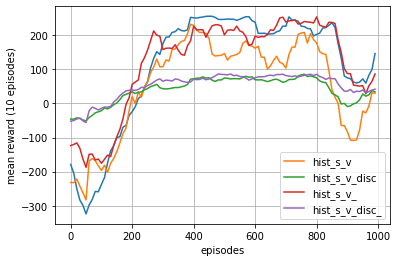

In [14]:
plt.grid(True)
plt.plot([i for i in range(0,len(hist_s[::10])*10,10)],np.convolve(hist_s[::10],np.ones(10)/10,mode='same'))
plt.plot([i for i in range(0,len(hist_s[::10])*10,10)],np.convolve(hist_s_v,np.ones(10)/10,mode='same'),label='hist_s_v')
plt.plot([i for i in range(0,len(hist_s[::10])*10,10)],np.convolve(hist_s_v_disc,np.ones(10)/10,mode='same'),label='hist_s_v_disc')
plt.plot([i for i in range(0,len(hist_s[::10])*10,10)],np.convolve(hist_s_v_,np.ones(10)/10,mode='same'),label='hist_s_v_')
plt.plot([i for i in range(0,len(hist_s[::10])*10,10)],np.convolve(hist_s_v_disc_,np.ones(10)/10,mode='same'),label='hist_s_v_disc_')
plt.xlabel('episodes')
plt.ylabel('mean reward (10 episodes)')
plt.legend()

In [15]:
hist = np.array([[i for i in range(len(hist_s))],hist_s]).T

In [16]:
np.savetxt('st2.txt',hist)

In [17]:
rew_mult = 1
state = env.reset()
total_reward = 0
total_reward_disc = 0
agent_s.epsilon = 0
for t in range(t_max):
    action = agent_s.get_action([state], False)
    next_state, reward, done, _ = env.step(action_dict[action[0]])
    env.render()
    total_reward += reward
            
    total_reward_disc += rew_mult*reward
    rew_mult *= agent_s.gamma

    state = next_state

    if done:
        break
total_reward

134.32630450097312